### Simple 1D example of `Hilbert DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from util import (
    print_model_parameters,
    gp_sampler,
    get_torch_size_string,
    plot_1xN_torch_traj_tensor,
    plot_ddpm_1d_result,
    get_hbm_M,
)
from dataset import get_1d_training_data
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    DiffusionUNetLegacy,
    forward_sample,
    eval_ddpm_1d,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[1.12.0+cu113].


### Initialize

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
# for k_idx,key in enumerate(dc.keys()): print ("[%2d] key:[%s]"%(k_idx,key))
# plot_ddpm_constants(dc)

In [3]:
# Instantiate U-net
device = 'cuda:0' # mps, cpu
model = DiffusionUNetLegacy(
    name                 = 'unet',
    dims                 = 1,
    n_in_channels        = 1,
    n_base_channels      = 128,
    n_emb_dim            = 128,
    n_cond_dim           = 1,
    n_enc_blocks         = 5, # number of encoder blocks
    n_dec_blocks         = 5, # number of decoder blocks
    n_groups             = 16, # group norm paramter
    n_heads              = 4, # number of heads in QKV attention
    actv                 = nn.SiLU(),
    kernel_size          = 3, # kernel size (3)
    padding              = 1, # padding size (1)
    use_attention        = False,
    skip_connection      = True, # additional skip connection
    chnnel_multiples     = (1,2,2,4,8),
    updown_rates         = (1,1,2,2,2),
    use_scale_shift_norm = True,
    device               = device,
) # input:[B x C x L] => output:[B x C x L]
print ("Ready.")

Ready.


### Training data `x_0`: [N x C x L]
where N is the number of data, C is the channel size, and L is the length of trajectories

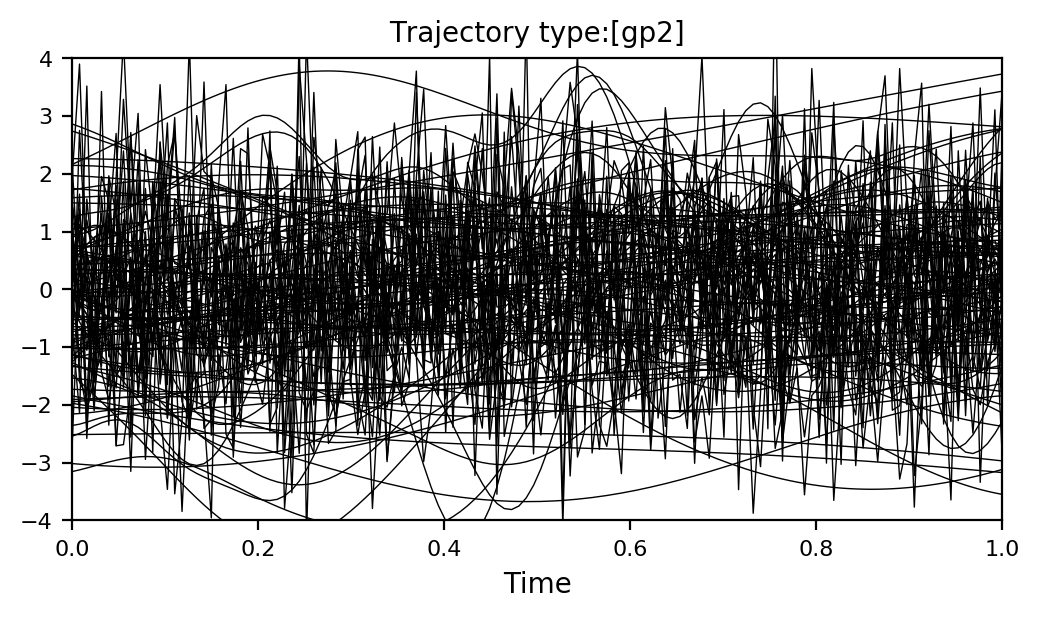

x_0:[100x1x128]


In [4]:
times,x_0, hyp_lens = get_1d_training_data(
    traj_type = 'gp2', # gp / step / step2
    n_traj    = 100,
    L         = 128,
    device    = device,
    seed      = 0,
    plot_data = True,
    figsize   = (6,3),
    ls        = '-',
    lc        = 'k',
    lw        = 1/2,
    verbose   = True
    )

### Multi-resolution Hilbert Spaces

In [5]:
M_list = []
M_list.append(
    th.from_numpy(np.eye(len(times))).to(th.float32).to(device)
)
for hyp_len in [0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    M = get_hbm_M(times,hyp_gain=1.0,hyp_len=0.1,device=device) # [L x L]
    M_list.append(M)
# M = None
print ("Hilbert Brownian motion ready.")

Hilbert Brownian motion ready.


### Train

In [6]:
# Configuration
max_iter    = int(5e4)
batch_size  = 128
print_every = 1e3
eval_every  = 2e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    
    # Zero gradient
    optm.zero_grad()
    
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:] # [B x C x L]
    cond_batch = hyp_lens[idx]
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).long() # [B]
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc,M_list) # [B x C x L]
    # Noise prediction
    noise_pred,_ = model(x_t_batch,step_batch,cond_batch) # [B x C x L]
    
    # Compute error
    loss = F.mse_loss(noise,noise_pred)+F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    
    # Update
    loss.backward()
    optm.step()
    schd.step()
    
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    
    # Evaluate
    # if (it%eval_every) == 0 or it == (max_iter-1):
    #     n_sample = 20
    #     step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
    #     M_eval = None
    #     x_t_list = eval_ddpm_1d(
    #         model,dc,n_sample,x_0,step_list_to_append,device,M_eval)
    #     plot_ddpm_1d_result(
    #         times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
    #         plot_ancestral_sampling=True,plot_one_sample=False,
    #         lw_gt=2,lw_sample=1/2,lc_gt=(0,1,0,0.3),lc_sample='k',
    #         ls_gt='-',ls_sample='--',ylim=(-4,+4),figsize=(5,3))

print ("Done.")

it:[      0][0.0]% loss:[2.0752]
it:[   1000][2.0]% loss:[0.7411]
it:[   2000][4.0]% loss:[0.5764]
it:[   3000][6.0]% loss:[0.4611]
it:[   4000][8.0]% loss:[0.3620]
it:[   5000][10.0]% loss:[0.3690]
it:[   6000][12.0]% loss:[0.3707]
it:[   7000][14.0]% loss:[0.3256]
it:[   8000][16.0]% loss:[0.3270]
it:[   9000][18.0]% loss:[0.3409]
it:[  10000][20.0]% loss:[0.2945]
it:[  11000][22.0]% loss:[0.2869]
it:[  12000][24.0]% loss:[0.3039]
it:[  13000][26.0]% loss:[0.2348]
it:[  14000][28.0]% loss:[0.2720]
it:[  15000][30.0]% loss:[0.2738]
it:[  16000][32.0]% loss:[0.2777]
it:[  17000][34.0]% loss:[0.2746]
it:[  18000][36.0]% loss:[0.3060]
it:[  19000][38.0]% loss:[0.2804]
it:[  20000][40.0]% loss:[0.2925]
it:[  21000][42.0]% loss:[0.2307]
it:[  22000][44.0]% loss:[0.2253]
it:[  23000][46.0]% loss:[0.2155]
it:[  24000][48.0]% loss:[0.2165]
it:[  25000][50.0]% loss:[0.2018]
it:[  26000][52.0]% loss:[0.2815]
it:[  27000][54.0]% loss:[0.2180]
it:[  28000][56.0]% loss:[0.2655]
it:[  29000][58.0]%

### Evaluate

hyp_len:[1.000e-03]


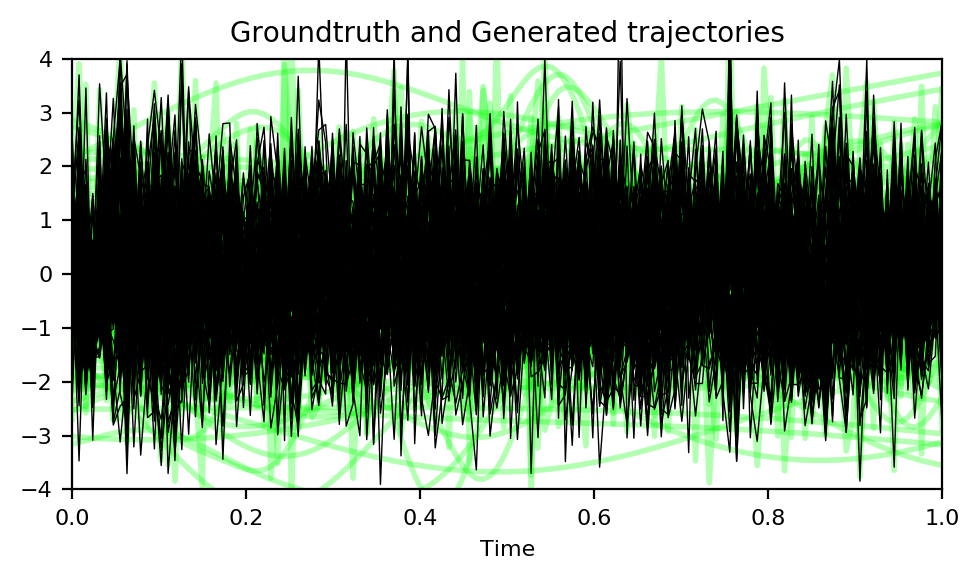

hyp_len:[1.000e-01]


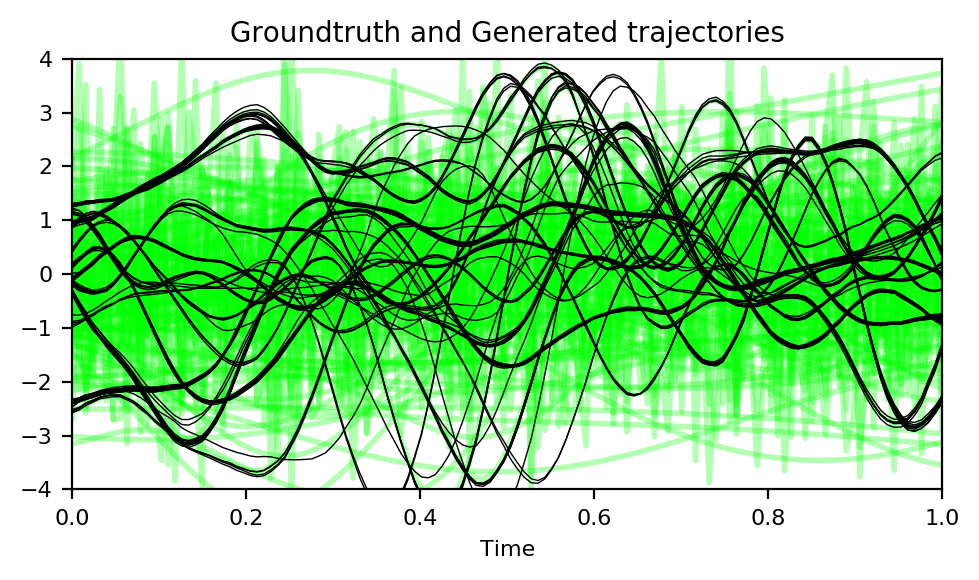

hyp_len:[2.000e-01]


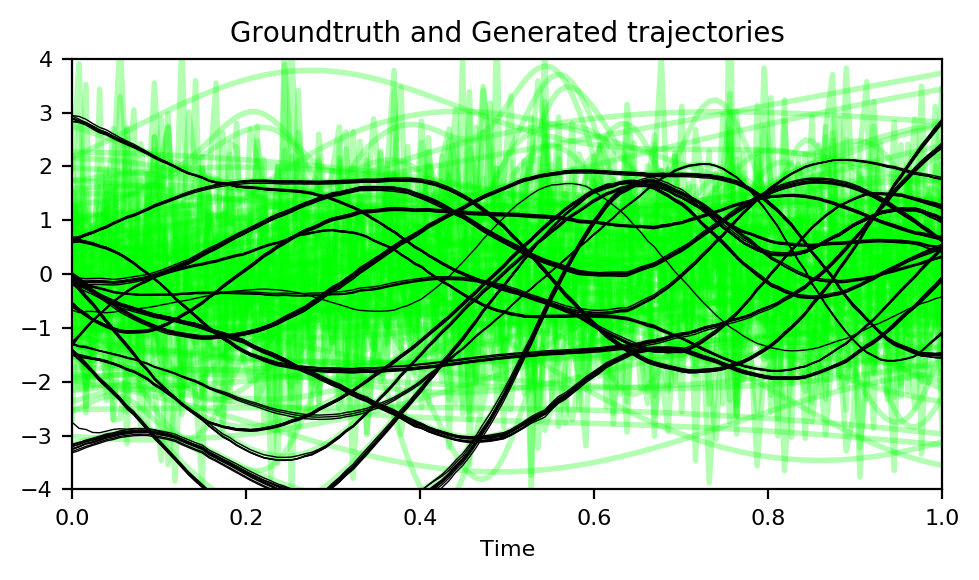

hyp_len:[4.000e-01]


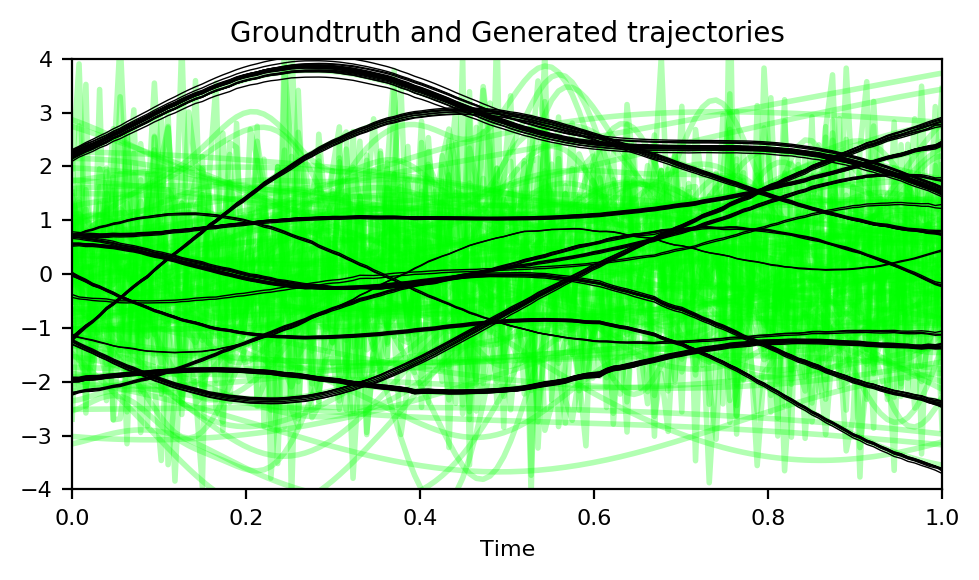

hyp_len:[6.000e-01]


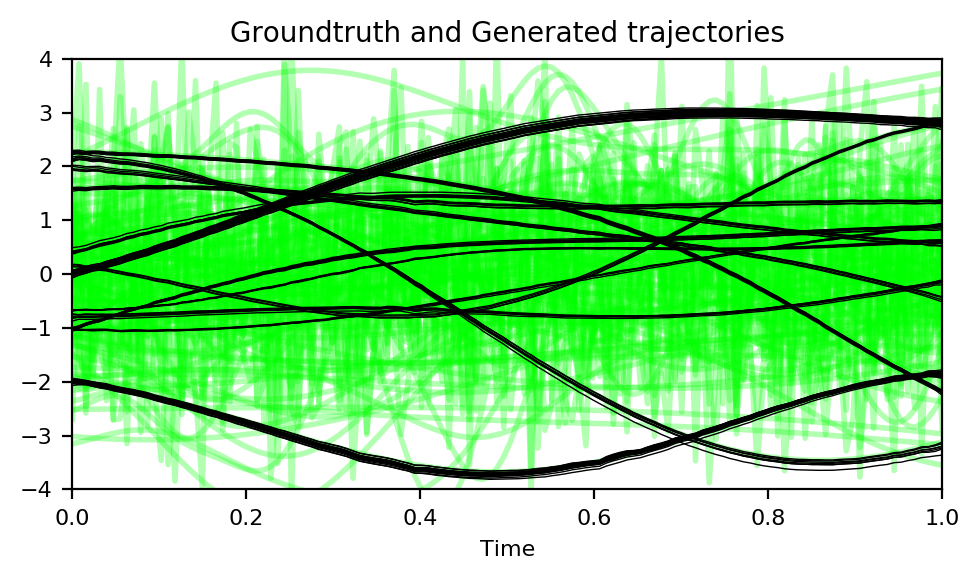

hyp_len:[8.000e-01]


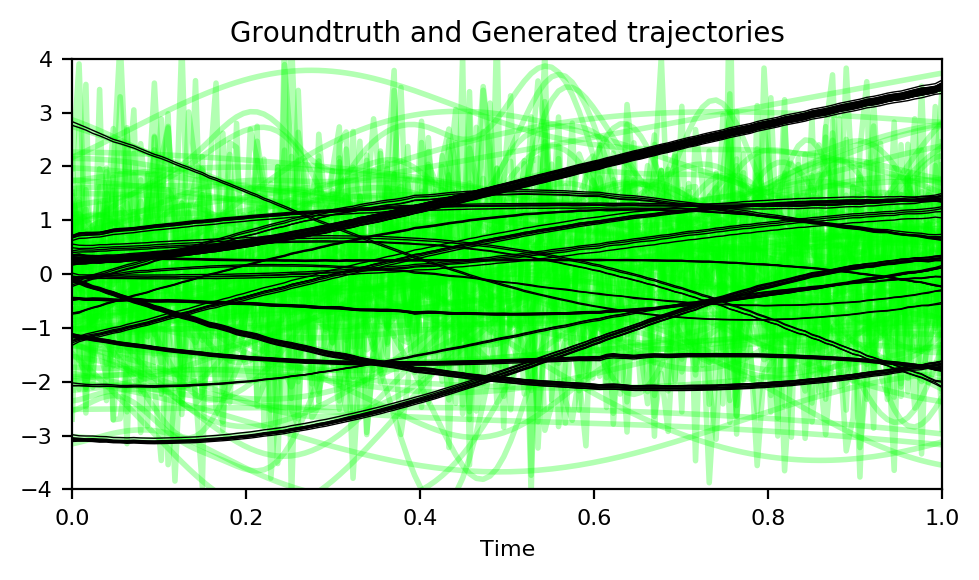

hyp_len:[1.000e+00]


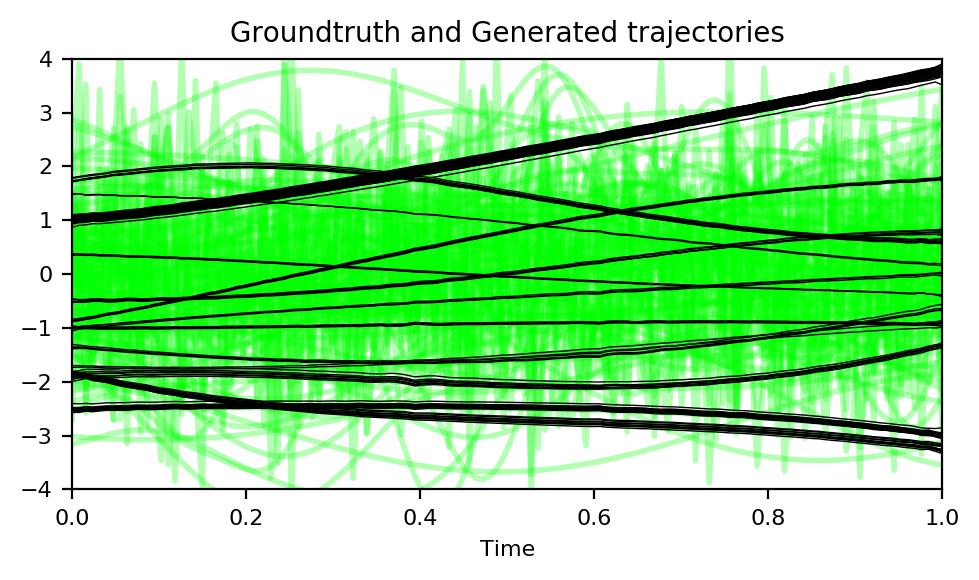

In [35]:
for hyp_len in [0.001, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
    print ("hyp_len:[%.3e]"%(hyp_len))
    n_sample = 100
    step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
    M_eval = get_hbm_M(times,hyp_gain=1.0,hyp_len=hyp_len,device=device)
    x_t_list = eval_ddpm_1d(
        model,dc,n_sample,x_0,step_list_to_append,device,None, M_eval, th.Tensor([hyp_len]*100).to(device).reshape(100,1))
    plot_ddpm_1d_result(
        times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
        plot_ancestral_sampling=False,plot_one_sample=False,
        lw_gt=2,lw_sample=1/2,lc_gt=(0,1,0,0.3),lc_sample='k',
        ls_gt='-',ls_sample='-',ylim=(-4,+4),figsize=(5,3))

In [34]:
th.Tensor([hyp_len]*100).to(device).reshape(100,1)

torch.Size([100])

In [31]:
th.Tensor(1)

tensor([9.646e-29])